In [1]:
#!pip download lifelines
#%pip install input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
#%pip install input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
#%pip install input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import rankdata 
import numpy as np
from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor

from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb

from metric import score

In [3]:
# set analysis output directory
def create_output_directory(output_path):
    """Create the output directory if it doesn't exist and set plotting style."""
    os.makedirs(output_path, exist_ok=True)
    return output_path

output_path = 'working/analysis'
create_output_directory(output_path)

'working/analysis'

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("input/data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("input/data/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


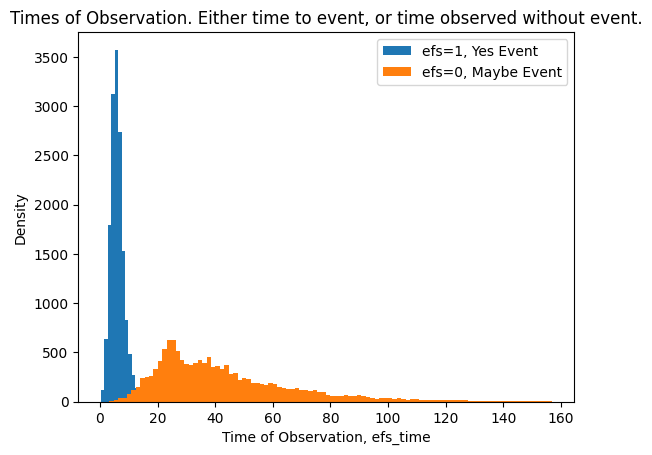

In [5]:
# Train targets
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.savefig(f'{output_path}times_of_observation.png')
plt.show()

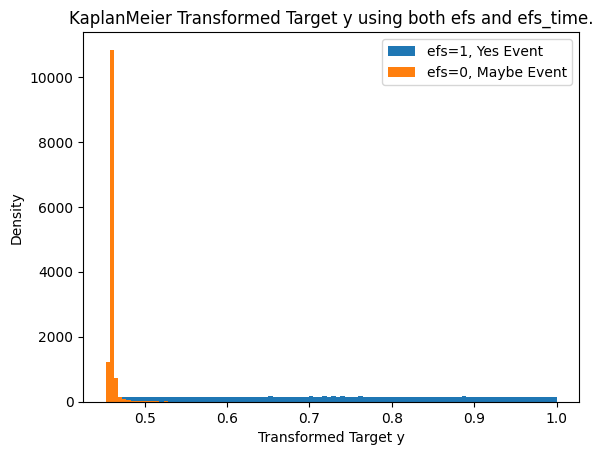

In [6]:
# Transform Two Targets into One Target with KaplanMeier
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}kaplanmeier_transformed_target_y.png')
plt.show()

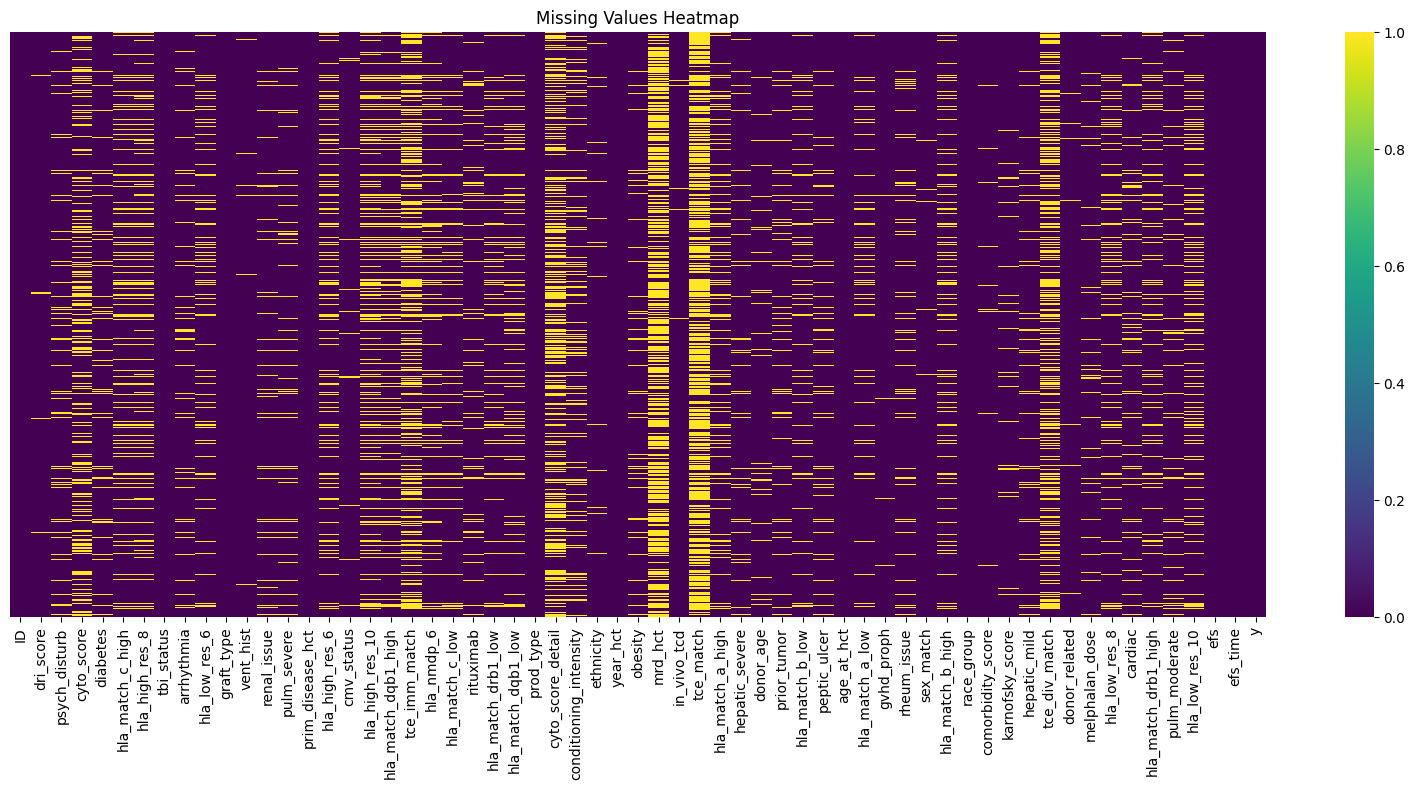

In [7]:
# missing values heatmap
def plot_missing_values_heatmap(df, output_path):
    plt.figure(figsize=(16, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_heatmap.png')
    plt.show()
    plt.close()

plot_missing_values_heatmap(train, output_path)

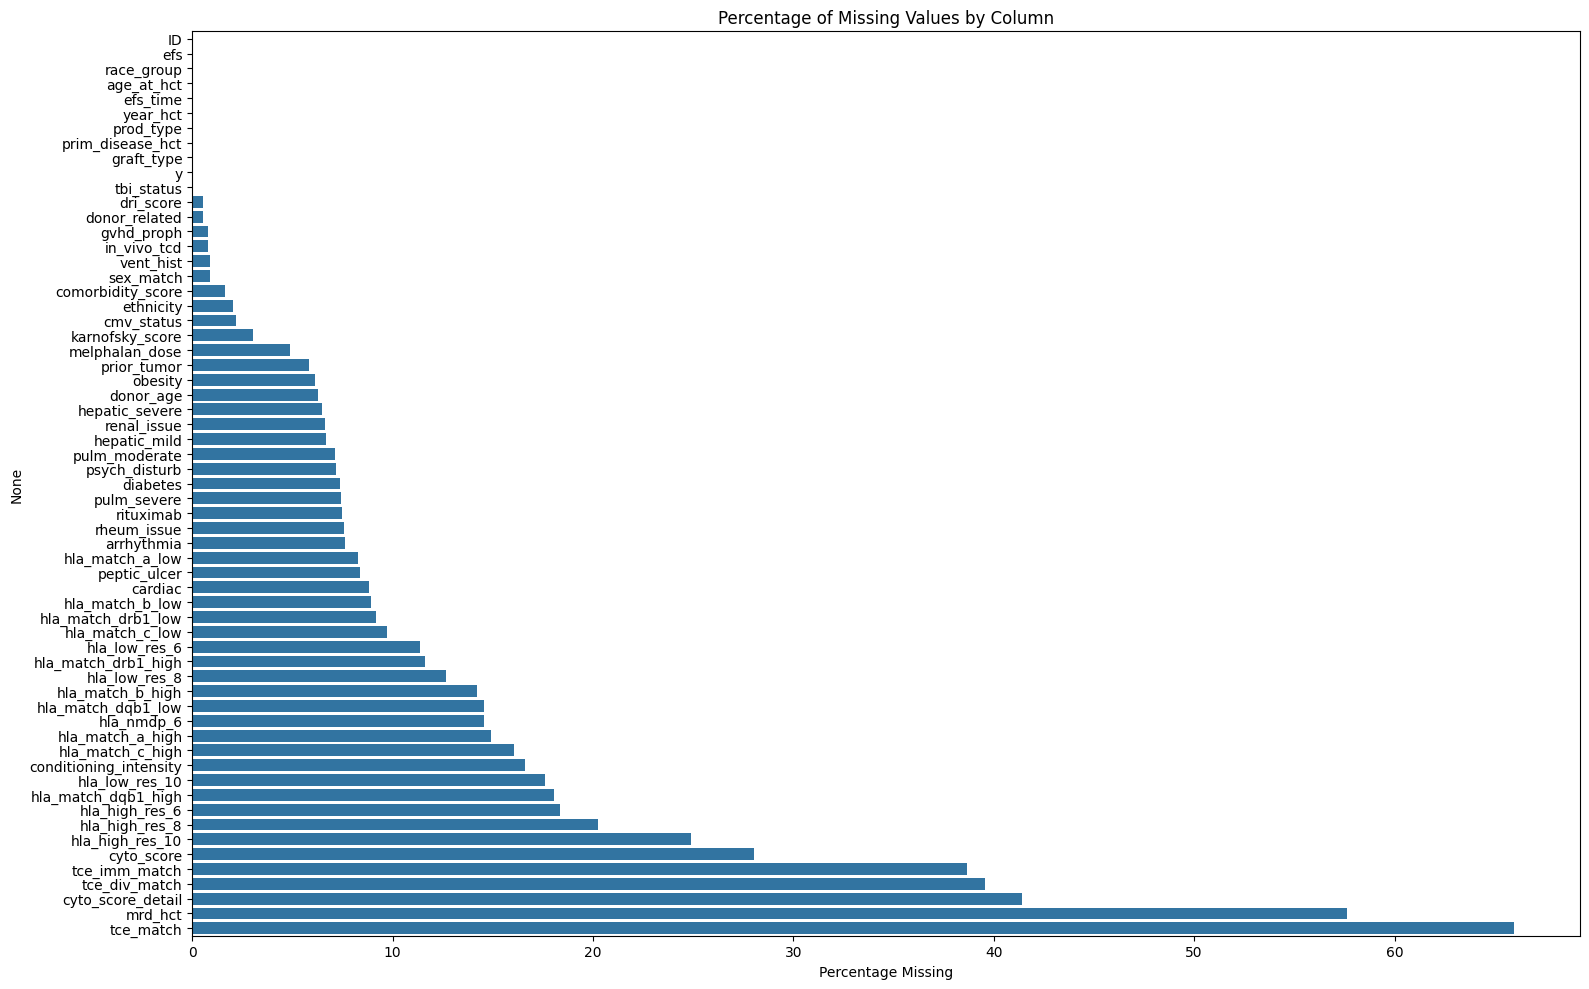

In [8]:
# missing value percentages
def plot_missing_values_bars(df, output_path):
    plt.figure(figsize=(16, 10))
    missing_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index)
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_percentage.png')
    plt.show()
    plt.close()

plot_missing_values_bars(train, output_path)

In [9]:
# numerical distributions
def plot_numerical_distributions(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    # Create progress bar for numerical distributions
    for col in tqdm(numerical_cols, desc="Creating distribution plots"):
        plt.figure(figsize=(10, 6))
        
        # Create subplot with histogram and kde
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Add statistical annotations
        stats_text = f'Mean: {df[col].mean():.2f}\n'
        stats_text += f'Median: {df[col].median():.2f}\n'
        stats_text += f'Std: {df[col].std():.2f}'
        plt.text(0.95, 0.95, stats_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{output_path}/distribution_{col}.png')
        plt.close()

plot_numerical_distributions(train, output_path)

Creating distribution plots: 100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


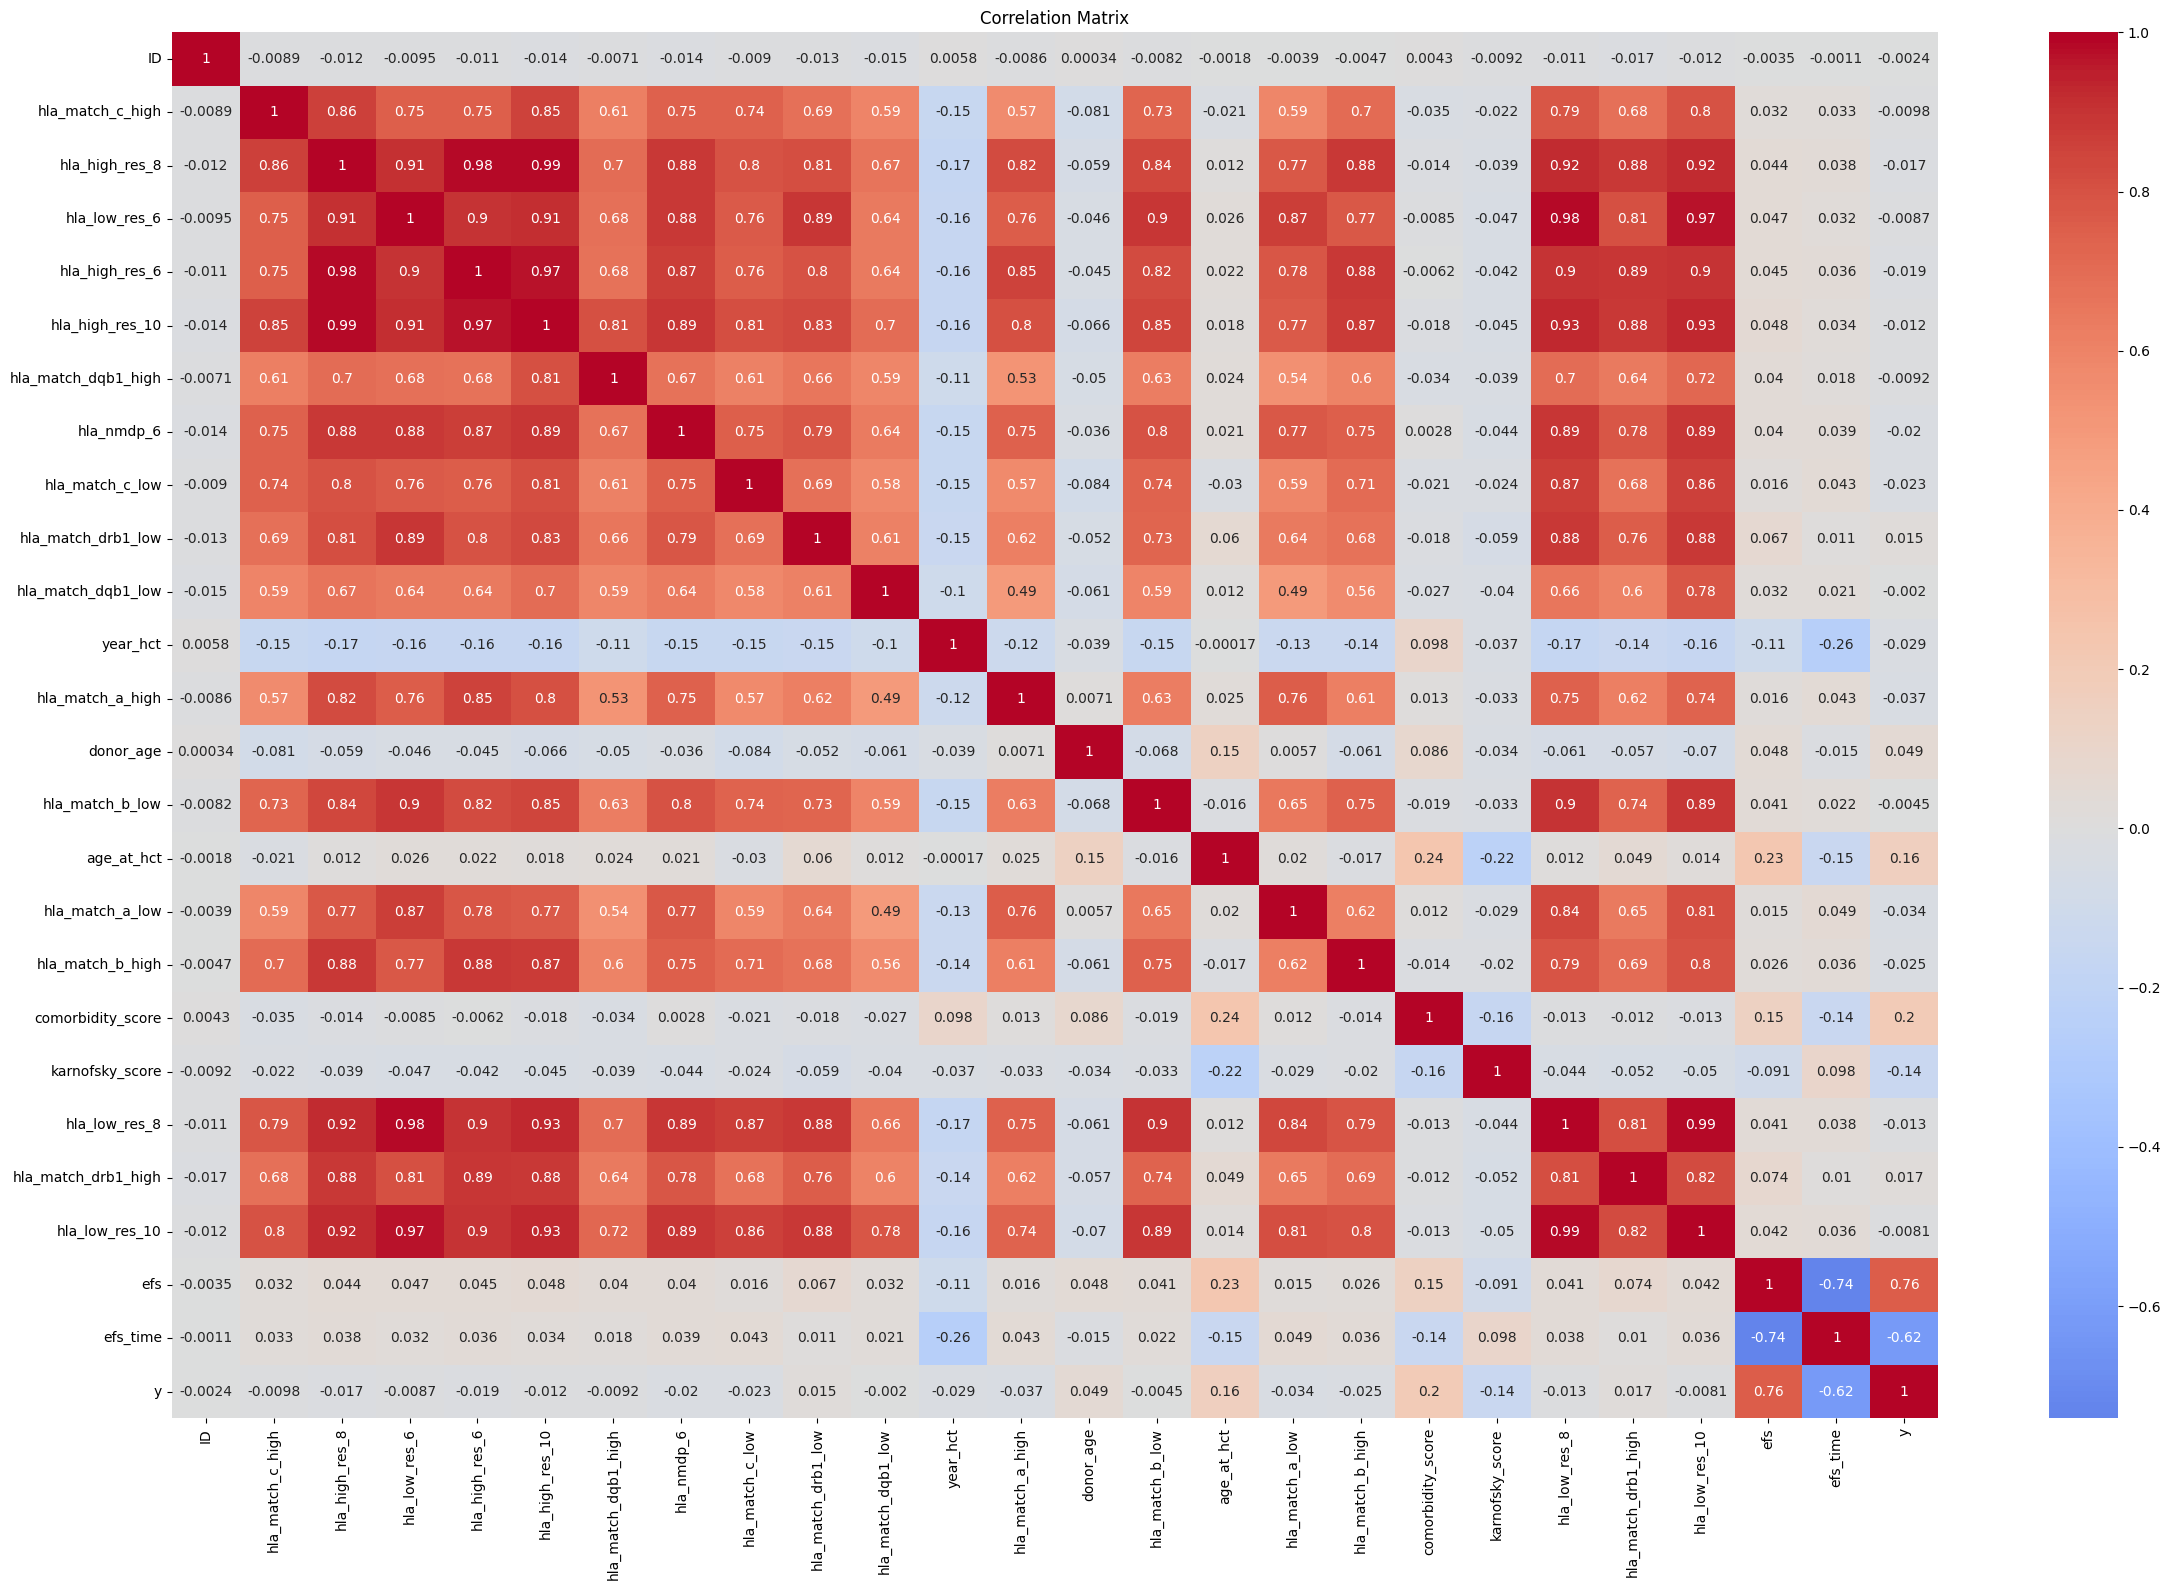

In [10]:
# correlation matrix
def plot_correlation_matrix(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    if len(numerical_cols) > 1:
        plt.figure(figsize=(24, 16))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig(f'{output_path}/correlation_matrix.png')
        plt.show()
        plt.close()

plot_correlation_matrix(train, output_path)

In [11]:
# categorical distributions
def plot_categorical_distributions(df, output_path):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in tqdm(categorical_cols, desc="Creating categorical plots"):
        if df[col].nunique() < 30:
            plt.figure(figsize=(12, 6))
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{output_path}/categorical_{col}.png')
            plt.close()

plot_categorical_distributions(train, output_path)

Creating categorical plots: 100%|██████████| 35/35 [00:02<00:00, 12.98it/s]


In [12]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"Number of Features: {len(FEATURES)} FEATURES: {FEATURES}")

Number of Features: 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [13]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [14]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [15]:
SEED = 9365

def perform_pca(train, test, n_components=None, random_state=42):
    # Remove rows with NaN values from both datasets
    train = train.dropna()
    test = test.dropna()

    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [16]:
# PCA 
# Extract the numerical columns to be used in the PCA
train_num = train.drop('ID', axis=1)
test_num = test.drop('ID', axis=1)

# Get numeric and categorical columns
numeric_columns = train.select_dtypes(include=['int32', 'float32']).columns
categorical_columns = train.select_dtypes(exclude=['int32', 'float32']).columns

# Split into numeric and categorical dataframes
train_numeric = train_num[numeric_columns]
test_numeric = test_num[numeric_columns]
train_categorical = train[categorical_columns]
test_categorical = test[categorical_columns]

# Scale the numeric columns
scaler = StandardScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_numeric),
    columns=train_numeric.columns
)
test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns
)

train_pca, test_pca, pca = perform_pca(train_scaled, test_scaled, n_components=15, random_state=SEED)

# Merge scaled numeric data with categorical data
train_final = pd.concat([train_scaled, train_categorical, train_pca], axis=1)
test_final = pd.concat([test_scaled, test_categorical, test_pca], axis=1)

Explained variance ratio of the components:
 [0.62185766 0.06945745 0.04496955 0.04163152 0.03752877 0.03326187
 0.0310978  0.02182666 0.01942037 0.01682323 0.0146363  0.01197398
 0.01041389 0.00941149 0.00871325]
0.9930237855849198


In [17]:
train_final.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,ID,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,cmv_status,tce_imm_match,rituximab,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,obesity,mrd_hct,in_vivo_tcd,tce_match,hepatic_severe,prior_tumor,peptic_ulcer,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate,efs,efs_time,y,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
0,NaN,NaN,0.709327,0.733688,NaN,0.587754,0.697842,0.556195,0.63089,0.529603,0.260175,0.640967,NaN,0.616327,-1.358153,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,42.356,0.458687,2.727902,0.680677,2.625381,-0.532921,-1.354262,-0.680601,-0.393779,0.079282,0.181626,0.015532,0.036167,0.050045,0.009715,0.016774,-0.011538
1,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,-2.276400,0.640967,1.952535,0.616327,0.238416,0.634834,0.645742,0.650656,0.559264,0.700679,0.635062,0.709252,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,1,1,0,0,1,1.0,4.672,0.847759,2.770907,-1.168875,0.428611,-1.212294,-1.475650,0.178804,0.530862,0.147279,0.165325,0.042375,-0.043604,0.093161,-0.012238,0.025481,-0.021794
2,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,1.211391,0.640967,NaN,0.616327,-0.220651,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,2,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,1,1,0,0,0,0.0,19.793,0.462424,2.388543,-0.397025,0.925259,0.823173,1.015365,0.278995,-0.266171,-0.078130,0.051433,-0.009313,0.115572,0.060928,-0.004854,-0.020767,-0.004700
3,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,-1.959328,0.640967,-0.870858,0.616327,0.216664,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,3,2,0,1,0,0,0,0,0,0,0,3,0,1,0,0,1,1,0,0,1,1,1,0,0,0,3,0,3,2,1,1,0,0,0,0,0.0,102.349,0.456661,-2.512538,-0.538401,-0.015757,0.656617,-0.489117,-0.513843,2.625676,-0.476571,1.067525,0.629441,-0.311109,-2.288686,-0.818882,-1.054024,0.314182
4,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,-0.133265,0.556195,0.63089,0.529603,0.894319,0.640967,0.937530,0.616327,-0.421955,0.634834,0.645742,-0.352148,0.559264,0.700679,0.635062,0.709252,4,2,0,0,0,0,0,1,0,0,0,4,0,0,0,1,0,1,1,0,0,0,0,0,0,0,4,0,0,3,0,1,1,1,0,0,0.0,16.223,0.464674,2.634422,-1.018418,0.525286,0.584591,0.471381,-0.296808,-0.077949,0.090776,0.091055,-0.030333,0.090522,-0.012158,0.003816,0.009906,-0.026349


In [18]:
test = test_final
train = train_final

# add pca columns to features list
FEATURES.extend(train_pca.columns.tolist())

In [19]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    'PC_1',
    'PC_2',
    'PC_3',
    'PC_4',
    'PC_5',
    'PC_6',
    'PC_7',
    'PC_8',
    'PC_9',
    'PC_10',
    'PC_11',
    'PC_12',
    'PC_13',
    'PC_14',
    'PC_15'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [21]:
train.dtypes

hla_match_c_high           float64
hla_high_res_8             float64
hla_low_res_6              float64
hla_high_res_6             float64
hla_high_res_10            float64
hla_match_dqb1_high        float64
hla_nmdp_6                 float64
hla_match_c_low            float64
hla_match_drb1_low         float64
hla_match_dqb1_low         float64
year_hct                   float64
hla_match_a_high           float64
donor_age                  float64
hla_match_b_low            float64
age_at_hct                 float64
hla_match_a_low            float64
hla_match_b_high           float64
comorbidity_score          float64
karnofsky_score            float64
hla_low_res_8              float64
hla_match_drb1_high        float64
hla_low_res_10             float64
ID                           int64
dri_score                 category
psych_disturb             category
cyto_score                category
diabetes                  category
tbi_status                category
arrhythmia          

In [ ]:
# Feature Engineering
def feature_engineering(df):
    # commorbity by age at hct
    df['comorbidity_age'] = df['comorbidity_score'] * df['age_at_hct']
    
    return df

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [27]:
train['comorbidity_age']

0        1.159252
1        0.155127
2        0.188337
3       -0.184933
4        0.148590
           ...   
28795   -0.503432
28796   -0.633455
28797    0.964985
28798    0.643095
28799   -0.265574
Name: comorbidity_age, Length: 28800, dtype: float64

In [28]:
# XGBoost with KaplanMeier
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.1.3


In [29]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17783
[500]	validation_0-rmse:0.15946
[1000]	validation_0-rmse:0.15752
[1500]	validation_0-rmse:0.15685
[1999]	validation_0-rmse:0.15663


d:\Projects\CIBMTR\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17362
[500]	validation_0-rmse:0.15577
[1000]	validation_0-rmse:0.15430
[1500]	validation_0-rmse:0.15395
[1999]	validation_0-rmse:0.15381
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17732
[500]	validation_0-rmse:0.15828
[1000]	validation_0-rmse:0.15669
[1500]	validation_0-rmse:0.15633
[1999]	validation_0-rmse:0.15621
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17931
[500]	validation_0-rmse:0.16025
[1000]	validation_0-rmse:0.15831
[1500]	validation_0-rmse:0.15761
[1999]	validation_0-rmse:0.15729
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17377
[500]	validation_0-rmse:0.15729
[1000]	validation_0-rmse:0.15586
[1500]	validation_0-rmse:0.15525
[1999]	validation_0-rmse:0.15494
#########################
### Fold 6
#########################
[0]	validation_0-rmse:0.17758
[500]	valid

In [30]:
# XGBoost with KaplanMeier
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.1.3


In [31]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    #'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    #'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    #'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    #'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    #'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [32]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17782
[500]	validation_0-rmse:0.15965
[1000]	validation_0-rmse:0.15732
[1500]	validation_0-rmse:0.15648
[1999]	validation_0-rmse:0.15602
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17364
[500]	validation_0-rmse:0.15561
[1000]	validation_0-rmse:0.15412
[1500]	validation_0-rmse:0.15355
[1999]	validation_0-rmse:0.15340
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17734
[500]	validation_0-rmse:0.15805
[1000]	validation_0-rmse:0.15607
[1500]	validation_0-rmse:0.15536
[1999]	validation_0-rmse:0.15509
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17933
[500]	validation_0-rmse:0.16008
[1000]	validation_0-rmse:0.15800
[1500]	validation_0-rmse:0.15718
[1999]	validation_0-rmse:0.15675
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17377
[500]	valid

In [33]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

d:\Projects\CIBMTR\metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.6726515897196792


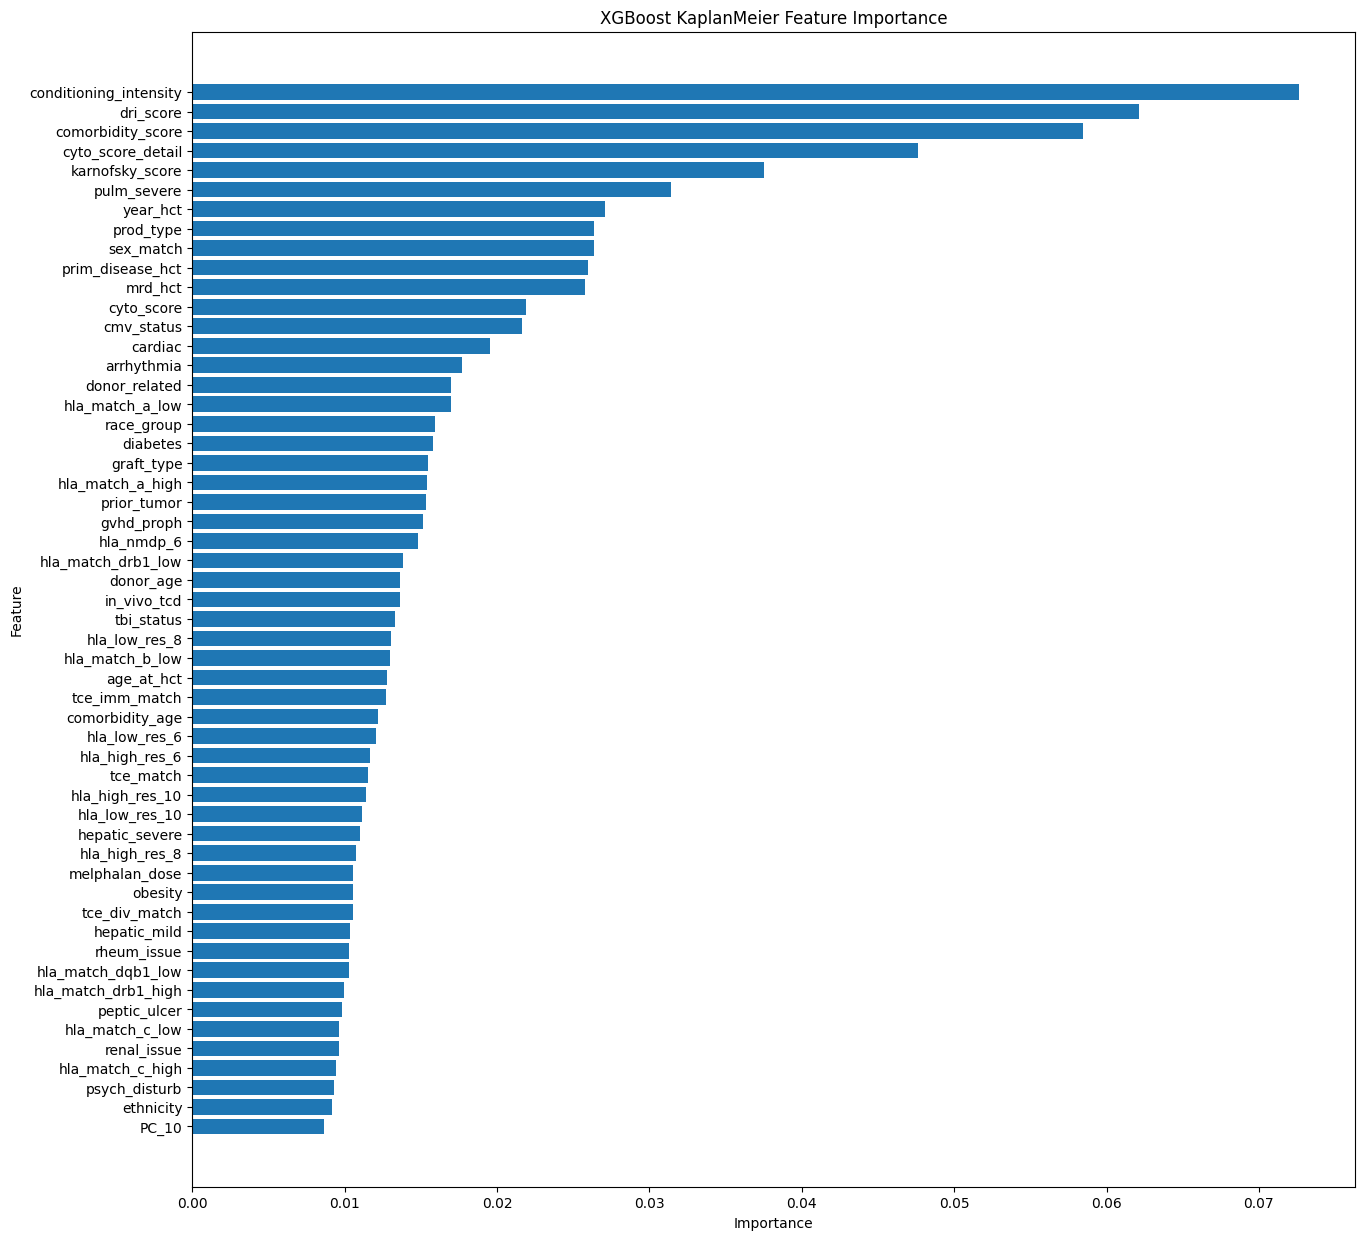

In [34]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}xgboost_km_feature_importance.png')
plt.show()

In [ ]:
# CatBoost with KaplanMeier
print("Using CatBoost version",cb.__version__)

In [24]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    #'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    #'hla_match_c_low',
    #'rituximab',
    #'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    #'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    'PC_1',
    'PC_2',
    'PC_3',
    'PC_4',
    'PC_5',
    'PC_6',
    'PC_7',
    'PC_8',
    'PC_9',
    'PC_10',
    'PC_11',
    'PC_12',
    'PC_13',
    'PC_14',
    'PC_15'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

In [ ]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}catboost_km_feature_importance.png')
plt.show()

In [ ]:
# LightGBM with KaplanMeier
print("Using LightGBM version",lgb.__version__)

In [29]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    'PC_1',
    'PC_2',
    'PC_3',
    'PC_4',
    'PC_5',
    'PC_6',
    'PC_7',
    'PC_8',
    'PC_9',
    'PC_10',
    'PC_11',
    'PC_12',
    'PC_13',
    'PC_14',
    'PC_15'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=3, 
        colsample_bytree=0.4,  
        #subsample=0.9, 
        n_estimators=2500, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m)

In [ ]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}lightgbm_km_feature_importance.png')
plt.show()

In [33]:
# XGBoost with Survival:Cox
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [34]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    #'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    'PC_1',
    'PC_2',
    'PC_3',
    'PC_4',
    'PC_5',
    'PC_6',
    'PC_7',
    'PC_8',
    'PC_9',
    'PC_10',
    'PC_11',
    'PC_12',
    'PC_13',
    'PC_14',
    'PC_15'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m)

In [ ]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}xgboost_cox_feature_importance.png')
plt.show()

In [38]:
# CatBoost with Survival:Cox
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    'PC_1',
    'PC_2',
    'PC_3',
    'PC_4',
    'PC_5',
    'PC_6',
    'PC_7',
    'PC_8',
    'PC_9',
    'PC_10',
    'PC_11',
    'PC_12',
    'PC_13',
    'PC_14',
    'PC_15'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",   
        iterations=400,     
        learning_rate=0.1,  
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

In [ ]:
feature_importance = model_cat_cox.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}catboost_cox_feature_importance.png')
plt.show()

In [ ]:
# Ensemble CAT and XGB and LGB
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
                     + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

In [ ]:
sub = pd.read_csv("input/data/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
                     + rankdata(pred_xgb_cox) + rankdata(pred_cat_cox)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()